In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import jax
import jax.numpy as jnp
from jax.experimental import host_callback
from tqdm.auto import tqdm
from functools import partial
import frozen_lake
import plotting
import qlearning
import actions
import mangoenv
import utils
import nets
import optuna

In [ ]:
@partial(jax.jit, static_argnames=("n_train_iter", "batch_size"))
def train_stage(rng_key, env, dql_state, replay_buffer, n_train_iter, batch_size):
    pbar = tqdm(total=n_train_iter, desc="Training")

    def train_step(dql_state, rng_key):
        rng_train, rng_eval = host_callback.id_tap(
            lambda a, t: pbar.update(1), jax.random.split(rng_key)
        )
        transitions = replay_buffer.sample(rng_train, batch_size)
        dql_state = dql_state.update_params(transitions)

        transitions = dql_state.greedy_rollout(env, rng_eval, steps=32)
        episodes = jnp.clip(transitions.done.sum(), a_min=1)
        accuracy = transitions.reward.sum() / episodes
        return dql_state, accuracy

    rng_steps = jax.random.split(rng_key, n_train_iter)
    dql_state, accuracy = jax.lax.scan(train_step, dql_state, rng_steps)
    return dql_state, accuracy

In [ ]:
def get_run_sim_fn(map_scale, p, cell_scales):
    def run_sim_fn(rng_key, rollout_steps, n_rollouts, stages_train_iter, batch_size):
        rng_env, rng_stages = jax.random.split(rng_key)
        rng_stages = jax.random.split(rng_stages, len(cell_scales))
        
        env = frozen_lake.FrozenLake.make_random(rng_env, map_scale, p)
        abs_env = env
        
        for cell_scale, rng_stage, train_iter in zip(cell_scales, rng_stages, stages_train_iter):
            rng_rollout, rng_setup, rng_train = jax.random.split(rng_stage, 3)

            # fill replay buffer with random rollouts
            episodes = utils.multi_random_rollout(abs_env, rng_rollout, rollout_steps, n_rollouts)
            replay_buffer = utils.CircularBuffer.store_episodes(episodes)

            # initialize DQL for current stage
            reward_fn = actions.get_reward_fn(cell_scale)
            beta_fn = actions.get_beta_fn(cell_scale)
            qnet = nets.MultiTaskQnet(abs_env.action_space.n, n_comands=5)
            dql_state = qlearning.MultiDQLTrainState.create(
                rng_setup, qnet, abs_env, reward_fn=reward_fn, beta_fn=beta_fn,
            )

            # train DQL for current stage
            dql_state, rewards = train_stage(
                rng_train, abs_env, dql_state, replay_buffer, train_iter, batch_size
            )

            # setup for next stage
            abs_env = mangoenv.MangoEnv.from_dql_state(abs_env, dql_state, max_steps=4)
            n_rollouts = n_rollouts // 2 

        rewards = jnp.concatenate([jnp.zeros(sum(stages_train_iter[:-1])), rewards])
        return rewards

    return run_sim_fn

In [ ]:
import matplotlib.pyplot as plt

def plot_rewards(rewards):
    def smooth(x, w=0.01):
        return jnp.convolve(x, jnp.ones(int(w * len(x))) / int(w * len(x)), mode="valid")
    for rew in rewards:
        plt.plot(smooth(rew))
    plt.plot(smooth(rewards.mean(axis=0)), label="mean", color="black", linewidth=3)
    plt.show()

In [ ]:
def get_objective_fn(map_scale, cell_scales, total_rollout_steps, total_train_iter, p=0.5):
    run_sim = get_run_sim_fn(map_scale, p, cell_scales)
    parrallel_run_sim = jax.vmap(run_sim, in_axes=(0, None, None, None, None))
    parrallel_run_sim = jax.jit(parrallel_run_sim, static_argnums=(1, 2, 3, 4))

    def objective(trial: optuna.Trial) -> jnp.float_:
        # attributes
        seed = trial.number
        trial.set_user_attr("seed", seed)
        trial.set_user_attr("max_steps", total_rollout_steps)
        trial.set_user_attr("total_train_iter", total_train_iter)
        trial.set_user_attr("map_scale", map_scale)
        trial.set_user_attr("cell_scales", cell_scales)

        rollout_steps = 2 ** trial.suggest_int("log_rollout_steps", 2, 7)  # 4 to 128
        # lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
        batch_size = 256 # 2 ** trial.suggest_int("log_batch_size", 6, 10)  # 64 to 1024
        train_iter = tuple(
            2 ** trial.suggest_int(f"log_train_iter_{i}", 6, int(jnp.log2(total_train_iter))) 
            for i in cell_scales[:-1] # 64 to max_train_iter
        ) 
        train_iter =  train_iter + (len(cell_scales)*total_train_iter - sum(train_iter),)
        n_rollouts = total_rollout_steps // rollout_steps

        rng_key = jax.random.PRNGKey(seed)
        rng_keys = jax.random.split(rng_key, 16)
        rewards = parrallel_run_sim(rng_keys, rollout_steps, n_rollouts, train_iter, batch_size)

        plot_rewards(rewards)
        return rewards.mean()

    return objective

[I 2024-02-27 01:38:39,345] A new study created in RDB with name: mango


  0%|          | 0/32 [00:00<?, ?it/s]

Random Rollout:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/4096 [00:00<?, ?it/s]

Greedy Rollout:   0%|          | 0/32 [00:00<?, ?it/s]

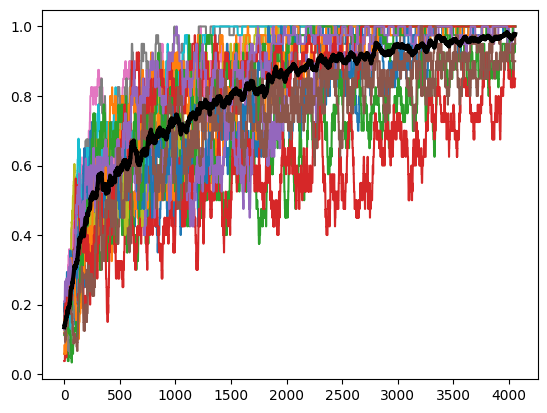

[I 2024-02-27 01:39:33,896] Trial 0 finished with value: 0.801342248916626 and parameters: {'log_rollout_steps': 3}. Best is trial 0 with value: 0.801342248916626.


Random Rollout:   0%|          | 0/16 [00:00<?, ?it/s]

Training:   0%|          | 0/4096 [00:00<?, ?it/s]

Greedy Rollout:   0%|          | 0/32 [00:00<?, ?it/s]

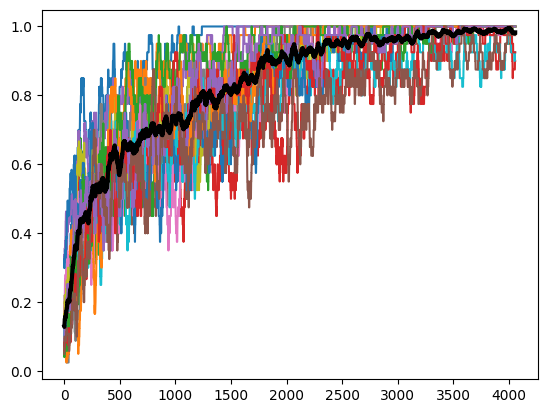

[I 2024-02-27 01:40:26,752] Trial 1 finished with value: 0.8298672437667847 and parameters: {'log_rollout_steps': 4}. Best is trial 1 with value: 0.8298672437667847.


Random Rollout:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/4096 [00:00<?, ?it/s]

Greedy Rollout:   0%|          | 0/32 [00:00<?, ?it/s]

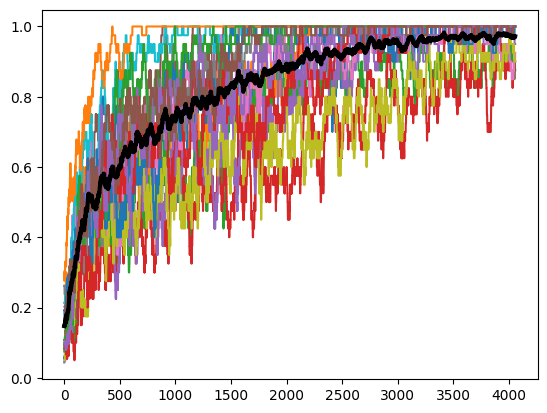

[I 2024-02-27 01:41:18,655] Trial 2 finished with value: 0.820750892162323 and parameters: {'log_rollout_steps': 6}. Best is trial 1 with value: 0.8298672437667847.


Random Rollout:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4096 [00:00<?, ?it/s]

Greedy Rollout:   0%|          | 0/32 [00:00<?, ?it/s]

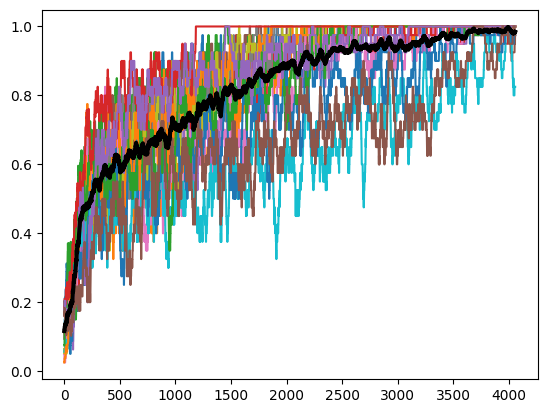

[I 2024-02-27 01:42:10,261] Trial 3 finished with value: 0.8130648136138916 and parameters: {'log_rollout_steps': 2}. Best is trial 1 with value: 0.8298672437667847.


Random Rollout:   0%|          | 0/128 [00:00<?, ?it/s]

Training:   0%|          | 0/4096 [00:00<?, ?it/s]

Greedy Rollout:   0%|          | 0/32 [00:00<?, ?it/s]

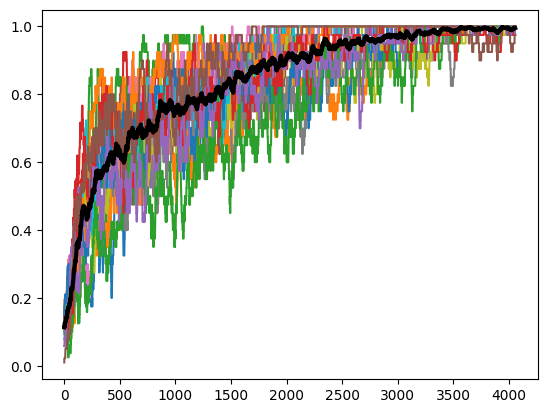

[I 2024-02-27 01:43:01,690] Trial 4 finished with value: 0.83484947681427 and parameters: {'log_rollout_steps': 7}. Best is trial 4 with value: 0.83484947681427.


Random Rollout:   0%|          | 0/32 [00:00<?, ?it/s]

Training:   0%|          | 0/4096 [00:00<?, ?it/s]

Greedy Rollout:   0%|          | 0/32 [00:00<?, ?it/s]

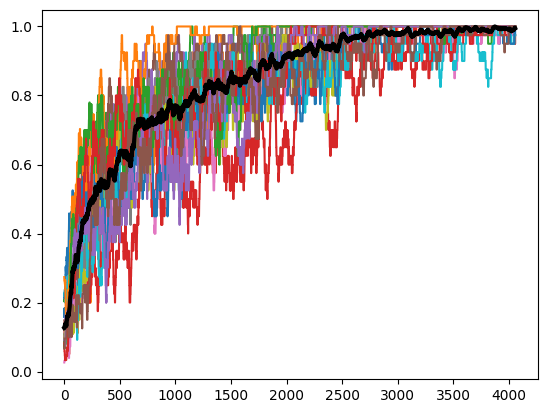

[I 2024-02-27 01:43:53,168] Trial 5 finished with value: 0.8375990390777588 and parameters: {'log_rollout_steps': 5}. Best is trial 5 with value: 0.8375990390777588.


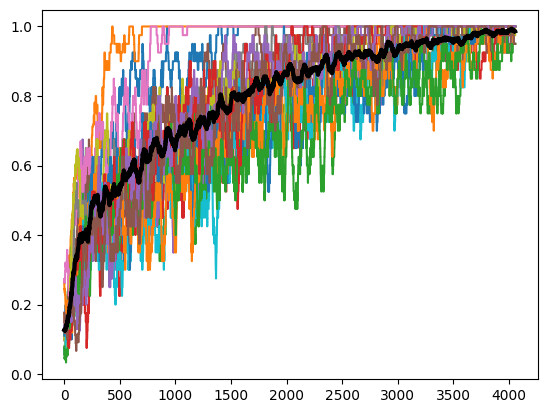

[I 2024-02-27 01:44:39,297] Trial 6 finished with value: 0.7904157638549805 and parameters: {'log_rollout_steps': 5}. Best is trial 5 with value: 0.8375990390777588.


In [ ]:
map_scale = 3
cell_scales = ( 3, 2, 1)

storage_path = f"sqlite:///optuna_studies/{2**map_scale}x{2**map_scale}_stages={list(cell_scales)}.db"
study = optuna.create_study(
    study_name=f"mango",
    storage=storage_path,
    load_if_exists=True,
    direction="maximize",
)
study.optimize(
    get_objective_fn(map_scale, cell_scales, total_train_iter=4*1024, total_rollout_steps=1024 * 1024),
    n_trials=32,
    show_progress_bar=True,
)

In [ ]:
map_scale = 2
cell_scales = (2,)
storage_path = f"{2**map_scale}x{2**map_scale}_stages={list(cell_scales)}.db"

cmd = f"optuna-dashboard 'sqlite:///optuna_studies/{storage_path}'"
get_ipython().system(cmd)

Traceback (most recent call last):
  File "/home/davide_sartor/.conda/envs/dl_env/lib/python3.10/site-packages/sqlalchemy/engine/base.py", line 1965, in _exec_single_context
    self.dialect.do_execute(
  File "/home/davide_sartor/.conda/envs/dl_env/lib/python3.10/site-packages/sqlalchemy/engine/default.py", line 921, in do_execute
    cursor.execute(statement, parameters)
sqlite3.OperationalError: no such table: version_info

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/davide_sartor/.conda/envs/dl_env/lib/python3.10/site-packages/optuna/storages/_rdb/storage.py", line 73, in _create_scoped_session
    yield session
  File "/home/davide_sartor/.conda/envs/dl_env/lib/python3.10/site-packages/optuna/storages/_rdb/storage.py", line 1043, in _init_version_info_model
    version_info = models.VersionInfoModel.find(session)
  File "/home/davide_sartor/.conda/envs/dl_env/lib/python3.10/site-packages/optuna/storages/_rd